<a href="https://colab.research.google.com/github/MHaan91/fastai/blob/master/Test_Fastai_v2%26DICOM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is created using the 'RSNA Pneumonia Detection Challange' dataset, link: https://www.kaggle.com/c/rsna-pneumonia-detection-challenge

**Requirements:**

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
!pip install pydicom -q
!pip install kornia===0.2.0
!pip install fastai2 -q

     |████████████████████████████████| 35.5MB 89kB/s 
     |████████████████████████████████| 143kB 5.2MB/s 
     |████████████████████████████████| 194kB 4.6MB/s 


In [3]:
from fastai2.basics import *
from fastai2.callback.all import *
from fastai2.vision.all import *
from fastai2.medical.imaging import *

import pydicom
import pandas as pd

In [4]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"

In [6]:
!nvidia-smi -L # Check which GPU the Colab instance is running.

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-30db22b0-6db9-360f-256c-bb32115a4e4a)


**Loading the Dataset:**

In [9]:
pneumonia_source = Path(root_dir + 'Datasets/rsna-pneumonia-detection-challenge/')
pneumonia_img = pneumonia_source/"stage_2_train_images/"
pneumonia_source.ls()

(#8) [Path('/content/gdrive/My Drive/Datasets/rsna-pneumonia-detection-challenge/stage_2_detailed_class_info.csv'),Path('/content/gdrive/My Drive/Datasets/rsna-pneumonia-detection-challenge/GCP Credits Request Link - RSNA.txt'),Path('/content/gdrive/My Drive/Datasets/rsna-pneumonia-detection-challenge/stage_2_sample_submission.csv'),Path('/content/gdrive/My Drive/Datasets/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv'),Path('/content/gdrive/My Drive/Datasets/rsna-pneumonia-detection-challenge/stage_2_train_images'),Path('/content/gdrive/My Drive/Datasets/rsna-pneumonia-detection-challenge/stage_2_test_images'),Path('/content/gdrive/My Drive/Datasets/rsna-pneumonia-detection-challenge/df_tst'),Path('/content/gdrive/My Drive/Datasets/rsna-pneumonia-detection-challenge/df_trn')]

In [15]:
items = get_dicom_files(pneumonia_img)

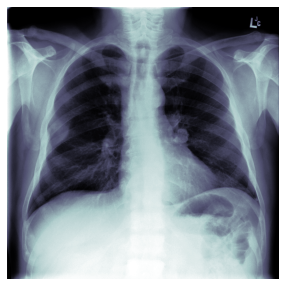

In [16]:
patient = 0
xray_sample = dcmread(items[patient])
xray_sample.show()

In [17]:
df = pd.read_csv(pneumonia_source/f"stage_2_train_labels.csv")
df.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [18]:
df['Target'].value_counts()

0    20672
1     9555
Name: Target, dtype: int64

In [19]:
dfsmall = df[:5000]
dfsmall.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [20]:
dfsmall['Target'].value_counts()

0    2633
1    2367
Name: Target, dtype: int64

Imbalanced classes on the full dataset, so we need to balance them using over/undersampling or a weighted loss function.


**Creating class weights:**

In [ ]:
# To Do

**Creating a DataBlock:**

In [21]:
bs = 256
size = 128

In [22]:
pneumonia = DataBlock(blocks=(ImageBlock(cls=PILDicom), CategoryBlock),                   
                   get_x=lambda x:pneumonia_img/f"{x[0]}.dcm",                   
                   get_y=lambda x:x[5],           
                   splitter=RandomSplitter(valid_pct=0.2, seed=30),        
                   item_tfms=Resize(460),
                   batch_tfms=[*aug_transforms(size=size, do_flip=False, max_rotate=15., max_zoom=1.1, max_lighting=.1, max_warp=0.1, p_affine=0.75, p_lighting=0.75),
                   Normalize.from_stats(*imagenet_stats)])

In [23]:
dls = pneumonia.dataloaders(dfsmall, bs=bs)

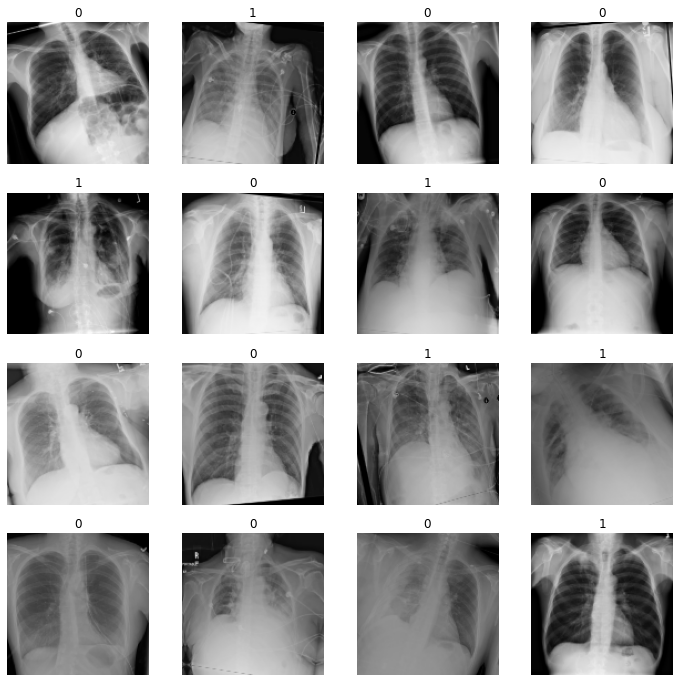

In [24]:
dls.show_batch(max_n=16)

In [25]:
#archname = xse_resnext18(pretrained=False, act_cls=Mish, sa=True, n_out=2)
#archname = xresnet34(pretrained=False, act_cls=Mish, sa=True, n_out=2, c_in=3)
archname = xse_resnext50(pretrained=False, act_cls=Mish, sa=True, n_out=2, c_in=3)

In [26]:
# MaxBlurPool
# Adopted from: https://discuss.pytorch.org/t/how-can-i-replace-an-intermediate-layer-in-a-pre-trained-network/3586/7
import kornia
def convert_MP_to_blurMP(model, layer_type_old):
    conversion_count = 0
    for name, module in reversed(model._modules.items()):
        if len(list(module.children())) > 0:
            # recurse
            model._modules[name] = convert_MP_to_blurMP(module, layer_type_old)

        if type(module) == layer_type_old:
            layer_old = module
            layer_new = kornia.contrib.MaxBlurPool2d(3, True)
            model._modules[name] = layer_new

    return model

In [27]:
blurarchname = convert_MP_to_blurMP(archname, nn.MaxPool2d)

In [28]:
#learn = cnn_learner(dls, opt_func=RAdam, arch=archname, wd=0.1, metrics=accuracy)#.to_fp16()
learn = Learner(dls, model=blurarchname, loss_func=LabelSmoothingCrossEntropy(), opt_func=ranger, metrics=[accuracy], wd=1e-2).to_fp16() #weight=weights

In [29]:
learn.summary()

XResNet (Input shape: ['256 x 3 x 128 x 128'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               256 x 32 x 64 x 64   864        True      
________________________________________________________________
BatchNorm2d          256 x 32 x 64 x 64   64         True      
________________________________________________________________
Mish                 256 x 32 x 64 x 64   0          False     
________________________________________________________________
Conv2d               256 x 32 x 64 x 64   9,216      True      
________________________________________________________________
BatchNorm2d          256 x 32 x 64 x 64   64         True      
________________________________________________________________
Mish                 256 x 32 x 64 x 64   0          False     
________________________________________________________________
Conv2d               256 x 64 x 64 x 64   18,432     True      
___________________________________________________

In [ ]:
learn.lr_find()

In [ ]:
lr = 3e-3

In [ ]:
learn.fit_flat_cos(10, lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.702277,0.676587,0.666000,08:19
1,0.655903,0.592948,0.726000,03:08
2,0.621843,0.558663,0.773000,03:07
3,0.598851,0.562381,0.767000,03:07
4,0.582107,0.530847,0.781000,03:08
5,0.565350,0.499757,0.799000,03:07
6,0.553059,0.545173,0.776000,03:08
7,0.545063,0.529539,0.777000,03:08
8,0.536806,0.508529,0.790000,03:07
9,0.524316,0.487490,0.810000,03:08


In [ ]:
# Use fit_flat_cos with Ranger optimizer
# learn.fit_one_cycle(5, lr_max=lr)

In [ ]:
learn.save('stage-1-'+str(size)+'-'+'xresnext50small')

In [ ]:
learn.load('stage-1-'+str(size)+'-'+str(archname))

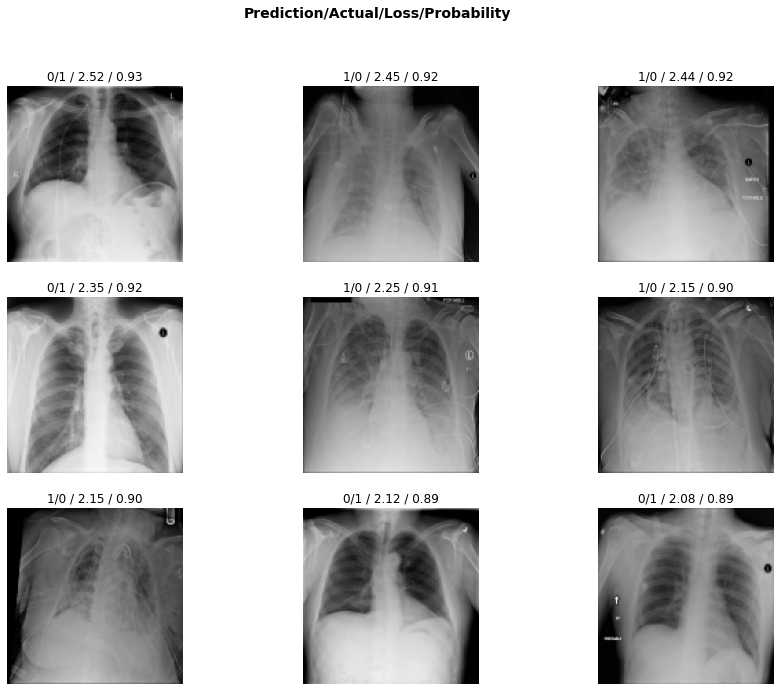

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
interp.plot_top_losses(9, figsize=(15,11))

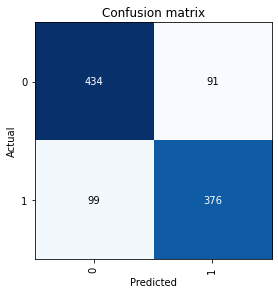

In [ ]:
interp.plot_confusion_matrix()

In [ ]:
learn.unfreeze()

SuggestedLRs(lr_min=1.737800776027143e-05, lr_steep=2.951209171442315e-05)

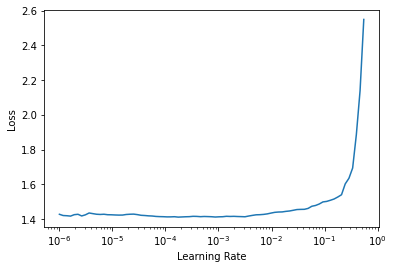

In [ ]:
learn.lr_find(start_lr=1e-6)

In [ ]:
# Use fit_flat_cos with Ranger optimizer.
# learn.fit_one_cycle(5, lr_max=slice(1e-5,1e-3))

In [ ]:
lrs = slice(lr/400, lr/4)

In [ ]:
learn.fit_flat_cos(10, lrs)

epoch,train_loss,valid_loss,accuracy,time
0,0.488114,0.488652,0.817000,03:08
1,0.491729,0.481683,0.813000,03:08
2,0.490149,0.481839,0.808000,03:08
3,0.486904,0.479890,0.816000,03:07
4,0.484961,0.485298,0.818000,03:08
5,0.483185,0.490170,0.815000,03:08
6,0.480388,0.487644,0.809000,03:07
7,0.478498,0.486370,0.814000,03:08
8,0.474364,0.476726,0.816000,03:07
9,0.469407,0.470893,0.816000,03:08


In [ ]:
learn.save('stage-2-'+str(size)+'-'+'xresnext50small')

In [ ]:
learn.load('stage-2-'+str(size)+'-'+str(archname))

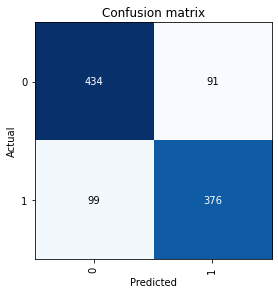

In [ ]:
interp.plot_confusion_matrix()